In [ ]:
# !pip3 install sklearn
# !pip3 install tqdm
# !pip3 install tensorboardX
!pip3 install timm
!pip3 install torchmetrics
!pip3 install albumentations

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch import optim
import pandas as pd
import numpy as np
from tqdm import tqdm
from tensorboardX import SummaryWriter
from timm.utils import AverageMeter
import random
import torchmetrics

/shared-libs/python3.7/py/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


File paths to the data

In [ ]:
# Kaggle
annotation_file_path = "../input/sorghum-id-fgvc-9/train_cultivar_mapping.csv"
img_dir_path = "../input/sorghum-id-fgvc-9/train_images"

# DeepNote
annotation_file_path = "data/train_cultivar_mapping.csv"
img_dir_path = "data/train_images"

In [ ]:
import pandas as pd
import albumentations as A
from pathlib import Path
from albumentations.core.composition import Compose, OneOf
from albumentations.pytorch import ToTensorV2

class DatasetParams:
    universe = pd.read_csv(Path("data") / "train_metadata_subset.csv")
    img_size = 512
    test_size = 0.38 # change to 0.2 later
    filepaths = {
        'train': Path("data") / "train.csv",
        'test': Path("data") / "test.csv"
    }
    imgdirpath = Path("data") / "train_images"

    # mean and std of each color channel
    # below is that of imagenet 
    norm_mean = [0.485, 0.456, 0.406]
    norm_std = [0.229, 0.224, 0.225]

DP = DatasetParams

DP.transforms = {
    'train': Compose([
                A.RandomResizedCrop(height=DP.img_size, width=DP.img_size),
                A.Flip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.ShiftScaleRotate(p=0.5),
                A.HueSaturationValue(p=0.5),
                A.OneOf([
                    A.RandomBrightnessContrast(p=0.5),
                    A.RandomGamma(p=0.5),
                ], p=0.5),
                A.OneOf([
                    A.Blur(p=0.1),
                    A.GaussianBlur(p=0.1),
                    A.MotionBlur(p=0.1),
                ], p=0.1),
                A.OneOf([
                    A.GaussNoise(p=0.1),
                    A.ISONoise(p=0.1),
                    A.GridDropout(ratio=0.5, p=0.2),
                    A.CoarseDropout(max_holes=16, min_holes=8, max_height=16, max_width=16, min_height=8, min_width=8, p=0.2)
                ], p=0.2),
                A.Normalize(
                    mean=DP.norm_mean,
                    std=DP.norm_std,
                ),
                ToTensorV2(),
            ]),
    
    'test': Compose([
                A.Resize(height=DP.img_size, width=DP.img_size),
                A.Normalize(
                    mean=DP.norm_mean,
                    std=DP.norm_std,
                ),
                ToTensorV2(),
            ])
}

DP.transforms_vis = {
    'train': Compose([
                A.RandomResizedCrop(height=DP.img_size, width=DP.img_size),
                A.Flip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.ShiftScaleRotate(p=0.5),
                A.HueSaturationValue(p=0.5),
                A.OneOf([
                    A.RandomBrightnessContrast(p=0.5),
                    A.RandomGamma(p=0.5),
                ], p=0.5),
                A.OneOf([
                    A.Blur(p=0.1),
                    A.GaussianBlur(p=0.1),
                    A.MotionBlur(p=0.1),
                ], p=0.1),
                A.OneOf([
                    A.GaussNoise(p=0.1),
                    A.ISONoise(p=0.1),
                    A.GridDropout(ratio=0.5, p=0.2),
                    A.CoarseDropout(max_holes=16, min_holes=8, max_height=16, max_width=16, min_height=8, min_width=8, p=0.2)
                ], p=0.2),
                ToTensorV2(),
            ]),
    
    'test': Compose([
                A.Resize(height=DP.img_size, width=DP.img_size),
                ToTensorV2(),
            ])
}

Split data into train and test 

In [ ]:
from pathlib import Path
from sklearn.model_selection import train_test_split
import pandas as pd
import random

img_labels = DP.universe
print(len(img_labels))

# quick macro for dividing a database into two disjunct ones based on a function that returns boolean
def filter(dataframe, key, lb, yes, no):
    for i, k in enumerate(dataframe[key].tolist()):
        if lb(k):
            yes.loc[len(yes)] = dataframe.loc[i]
        else:
            if no is not None:
                no.loc[len(no)] = dataframe.loc[i]

train = pd.DataFrame(columns=['image', 'cultivar'])
test = pd.DataFrame(columns=['image', 'cultivar'])
img_to_split = pd.DataFrame(columns=['image', 'cultivar'])

# isolate all class with only 1 training sample and put them in train
counts = img_labels['cultivar'].value_counts()
print(counts)
filter(img_labels, 'cultivar', lambda cultivar: counts[cultivar] == 1, train, img_to_split)

imgs = img_to_split['image'].tolist()
labels = img_to_split['cultivar'].tolist()

print(len(imgs), len(labels))

# use train_test_split with stratify to split class with multiple training samples
train_split, test_split = train_test_split(imgs, test_size=DP.test_size, stratify=labels)
print('train', train_split)
print('test_split', test_split, len(test_split))

filter(img_to_split, 'image', lambda image: image in train_split, train, test)

print('train', train)
print('test', test)

assert(len(img_labels) == len(train) + len(test))

train.to_csv(DP.filepaths['train'], index=False)
test.to_csv(DP.filepaths['test'], index=False)

165
PI_52606     6
PI_175919    5
PI_196049    5
PI_154987    4
PI_329338    4
            ..
PI_229841    1
PI_329310    1
PI_157804    1
PI_152967    1
PI_329301    1
Name: cultivar, Length: 83, dtype: int64
133 133
train ['2017-06-15__14-21-45-891.png', '2017-06-28__11-30-01-893.png', '2017-06-02__18-04-25-964.png', '2017-06-28__11-50-22-395.png', '2017-06-04__14-14-17-738.png', '2017-06-01__11-22-16-985.png', '2017-06-20__12-22-46-212.png', '2017-06-13__11-39-32-692.png', '2017-06-22__13-18-06-841.png', '2017-06-22__13-21-19-163.png', '2017-06-26__11-57-27-185.png', '2017-06-15__13-11-54-968.png', '2017-06-29__11-58-37-039.png', '2017-06-15__14-21-07-961.png', '2017-06-05__12-55-58-623.png', '2017-06-23__12-44-08-451.png', '2017-06-02__18-15-54-053.png', '2017-06-09__13-36-33-498.png', '2017-06-02__18-05-23-434.png', '2017-06-20__12-32-37-803.png', '2017-06-19__17-58-41-017.png', '2017-06-18__13-33-39-435.png', '2017-06-14__14-44-23-387.png', '2017-06-27__10-42-43-014.png', '2017-0

Define the dataset

In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision.transforms.functional import convert_image_dtype
import cv2
from sklearn import preprocessing

class CultivarDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        self.labelenc = preprocessing.LabelEncoder()
        self.labelenc.fit(self.img_labels['cultivar'].tolist())      

    def to_label(self, string: str):
        return self.labelenc.transform([string])[0]  

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])

        # NOTE: when pytorch reads an image, it is immediately transformed into a uint8 Tensor with each channel ranging in [0, 255]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = self.to_label(self.img_labels.iloc[idx, 1])

        if self.transform:
            image = self.transform(image=image)['image']
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label

# small test to make sure it's working as intended
c = CultivarDataset(
    annotations_file=DP.filepaths['train'],
    img_dir=DP.imgdirpath
)

print(c.to_label('PI_257599'))
print(c[0])
print(f'Make sure there is no garbage data: {c.img_labels[c.img_labels["image"].str.contains("2017")==False]}')
    

59
(array([[[112, 104,  58],
        [103,  99,  59],
        [104,  96,  59],
        ...,
        [ 72,  68,  47],
        [ 69,  67,  44],
        [ 52,  72,  63]],

       [[102, 107,  72],
        [102, 104,  72],
        [101, 109,  76],
        ...,
        [ 61,  67,  54],
        [ 62,  65,  54],
        [ 47,  66,  63]],

       [[110, 118,  82],
        [107, 117,  88],
        [102, 113,  89],
        ...,
        [ 61,  65,  53],
        [ 61,  61,  56],
        [ 46,  67,  70]],

       ...,

       [[119, 135, 112],
        [117, 134, 111],
        [123, 136, 114],
        ...,
        [ 96, 102,  81],
        [ 94, 107,  82],
        [ 71, 108, 109]],

       [[121, 138, 114],
        [120, 136, 113],
        [120, 137, 111],
        ...,
        [ 94, 103,  81],
        [ 96, 107,  84],
        [ 74, 113, 108]],

       [[103, 135, 133],
        [102, 136, 132],
        [101, 136, 126],
        ...,
        [ 79, 101,  94],
        [ 82, 107,  99],
        [ 62, 108, 1

In [ ]:
datasets = {
    'train': CultivarDataset(
                annotations_file=DP.filepaths['train'],
                img_dir=DP.imgdirpath,
                transform=DP.transforms['train']
            ),
    'test': CultivarDataset(
                annotations_file=DP.filepaths['test'],
                img_dir=DP.imgdirpath,
                transform=DP.transforms['test']
            )
}

print(datasets['train'][0])
print(datasets['test'][0])

(tensor([[[-0.2513, -0.3541, -0.3198,  ..., -1.2274, -1.2617, -1.2788],
         [-0.6109, -0.5424, -0.4054,  ..., -1.2617, -1.2617, -1.2445],
         [-0.7993, -0.6623, -0.5253,  ..., -1.2274, -1.2274, -1.2445],
         ...,
         [ 0.0741,  0.0741,  0.0741,  ...,  0.2111,  0.1254,  0.0741],
         [ 0.0912,  0.0912,  0.0912,  ..., -0.0287, -0.0801, -0.1143],
         [ 0.0912,  0.0912,  0.0912,  ...,  0.0056, -0.0629, -0.0972]],

        [[-0.3200, -0.3550, -0.3550,  ..., -1.0378, -1.0903, -1.0903],
         [-0.5126, -0.4776, -0.4251,  ..., -1.1253, -1.1253, -1.1078],
         [-0.6877, -0.6001, -0.4951,  ..., -1.1078, -1.1078, -1.1078],
         ...,
         [ 0.4678,  0.4678,  0.4853,  ...,  0.4853,  0.4153,  0.3803],
         [ 0.4853,  0.4853,  0.4853,  ...,  0.2752,  0.2402,  0.2227],
         [ 0.4853,  0.4853,  0.4853,  ...,  0.3102,  0.2577,  0.2402]],

        [[-0.5495, -0.5670, -0.5495,  ..., -1.0027, -1.0376, -1.0376],
         [-0.6367, -0.6367, -0.6193,  ..., -

<AxesSubplot:>

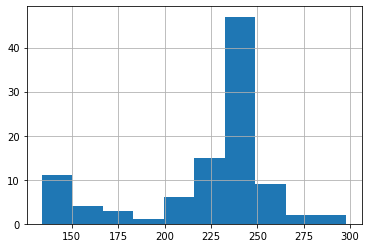

In [ ]:
data = pd.read_csv(annotation_file_path)
data.cultivar.value_counts().hist()

Notes on Hyperparameter:
- https://arxiv.org/pdf/1803.09820.pdf
- Momentum is usually always 0.9

In [ ]:
class CustomEffNet(nn.Module):
    def __init__(self, model_name='tf_efficientnet_b0_ns', pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        in_features = self.model.get_classifier().in_features
#         self.model.fc = nn.Linear(in_features, CFG.num_classes)
        self.model.classifier = nn.Sequential(
            nn.Linear(in_features, in_features),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(in_features, 100)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
# Hyperparameters
lr = 1e-4
max_lr = 1e-3
momentum = 0.9
weight_decay = 1e-5
epoches = 40

In [ ]:
def set_random_seed(seed=0, deterministic=False):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [ ]:
def cultivar_train(model, data_loader_train, optimizer, scheduler, criterion, metric, epoch, summary_writer):
    model.train()
    optimizer.zero_grad()
    loss_meter = AverageMeter()
    acc_meter = AverageMeter()
    # total_samples, correct = 0, 0
    with tqdm(enumerate(data_loader_train), total=len(data_loader_train)) as pbar:
        for idx, (samples, targets) in pbar:
            samples = samples.cuda()
            targets = targets.cuda()
            out = model(samples)
            pred = F.softmax(out)
            loss = criterion(pred, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_meter.update(loss.item(), targets.size(0))

            # Calculate accuracy
            acc = metric(pred.argmax(1).cpu(), targets.cpu())
            acc_meter.update(acc, 1)
            # _, predicted = torch.max(pred.data, 1)
            # total_samples += targets.size(0)
            # correct += (predicted == targets).sum().item()
            if idx%10==0:
                summary_writer.add_scalar(f'lr', scheduler.get_last_lr(), epoch*len(data_loader_train)+id)
            pbar.set_description(f"Train epoch {epoch}, loss: {loss: .4f}, accuracy: {acc: .4f}")

    return loss_meter.avg, acc_meter.avg

In [ ]:
def cultivar_val(model, data_loader_val, criterion, metric, epoch):
    model.eval()
    loss_meter = AverageMeter()
    acc_meter = AverageMeter()
    # total_samples, correct = 0, 0
    with tqdm(enumerate(data_loader_val), total=len(data_loader_val)) as pbar:
        for idx, (samples, targets) in pbar:
            samples = samples.cuda()
            targets = targets.cuda()
            out = model(samples)
            pred = F.softmax(out)
            loss = criterion(pred, targets)
            loss_meter.update(loss.item(), targets.size(0))
            
            # Calculate accuracy
            acc = metric(pred.argmax(1).cpu(), targets.cpu())
            acc_meter.update(acc, 1)
            # _, predicted = torch.max(pred.data, 1)
            # total_samples += targets.size(0)
            # correct += (predicted == targets).sum().item()
            pbar.set_description(f"Validation epoch {epoch}, loss: {loss: .4f}, accuracy: {acc: .4f}")
    
    return loss_meter.avg, acc_meter.avg

You need to run the `test.csv` and `train.csv` generation in `cultivardataset.ipynb` before running this!


The general procedure of k-fold is as follows:

- Shuffle the dataset randomly.
- Split the dataset into k groups
- For each unique group:
    - Take the group as a hold out or test data set
    - Take the remaining groups as a training data set
    - Fit a model on the training set and evaluate it on the test set
    - Retain the evaluation score and discard the model
- Summarize the skill of the model using the sample of model evaluation scores

In [ ]:
import timm

set_random_seed(seed=42)
print("Creating datasets...")

summary_writer = SummaryWriter()

print("Validation dataset created")
data_loader_train = torch.utils.data.DataLoader(
    datasets['train'],
    batch_size = 16,
    num_workers = 2,
    shuffle=True,
    pin_memory = True,
    drop_last = True
)

data_loader_val = torch.utils.data.DataLoader(
    datasets['test'],
    batch_size = 16,
    num_workers = 2,
    shuffle=False,
    pin_memory = True,
    drop_last = False
)

print("Dataloader created")
print("Creating model...")
model = CustomEffNet(model_name='tf_efficientnet_b3_ns', pretrained=True)
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                        epochs=epoches, steps_per_epoch=len(data_loader_train),
                                                        max_lr=max_lr, pct_start=0.2, 
                                                        div_factor=1e3, final_div_factor=1e3)
criterion = nn.CrossEntropyLoss()
metric = torchmetrics.Accuracy(threshold=0.5, num_classes=100)

min_loss = float('inf')

print("Start Training")
for epoch in range(epoches):
    loss_train, acc_train = cultivar_train(model, data_loader_train, optimizer, scheduler, criterion, metric, epoch, summary_writer)
    loss_val, acc_val = cultivar_val(model, data_loader_val, criterion, metric, epoch)
    min_loss = min(min_loss, loss_val)
    if min_loss == loss_val:
        save_state = {'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'epoch': epoch
                }

        save_path = f'ckpt_epoch_{epoch}.pth'
        print(f"{save_path} saving...")
        torch.save(save_state, save_path)
        print(f"{save_path} saved")

    print("Writing to summarywriter...")
    summary_writer.add_scalar(f'Loss/train', loss_train, epoch)
    summary_writer.add_scalar(f'Loss/val', loss_val, epoch)
    summary_writer.add_scalar(f'Acc/train', acc_train, epoch)
    summary_writer.add_scalar(f'Acc/val', acc_val, epoch)
    summary_writer.add_scalar(f'Min_loss', min_loss, epoch)

Creating datasets...
Validation dataset created
Dataloader created
Creating model...
Start Training
  0%|          | 0/7 [00:00<?, ?it/s]

KernelInterrupted: Execution interrupted by the Jupyter kernel.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d841b2e3-7f2f-42e6-ae8e-6cea1c0a3631' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>